# データ前処理

## インポート・設定

In [1]:
from pathlib import Path

import pandas as pd
import geopandas as gpd

In [2]:
DATA_DIR = Path("./data")
PROCESSED_DATA_DIR = Path("./data/processed")
PROCESSED_DATA_DIR.mkdir(exist_ok=True)

## 人口データ

### 読み込み

In [3]:
df_population = pd.read_csv(DATA_DIR / "population.csv")
df_population.head()

,表章項目,表章項目_階層,男女別,男女別_階層,人口,人口_階層,全国・都道府県,全国・都道府県_階層,時間軸（年）,時間軸（年）_階層,単位,値
0,人口,NaN,男女計,1,総人口,1,全国,1,2005年,1,千人,127768
1,人口,NaN,男女計,1,総人口,1,全国,1,2010年,1,千人,128057
2,人口,NaN,男女計,1,総人口,1,全国,1,2015年,1,千人,127095
3,人口,NaN,男女計,1,総人口,1,全国,1,2020年,1,千人,126146
4,人口,NaN,男女計,1,総人口,1,全国,1,2021年,1,千人,125502


### 前処理

In [4]:
def process_population(df_population: pd.DataFrame) -> pd.DataFrame:
    df = df_population.copy()

    # 全国のレコードを削除する
    df = df[~df["全国・都道府県"].eq("全国")].reset_index(drop=True)

    # 不要なカラムを削除する
    columns_to_drop = [
        "表章項目",
        "表章項目_階層",
        "男女別_階層",
        "人口_階層",
        "全国・都道府県_階層",
        "時間軸（年）_階層",
        "単位",
    ]
    df.drop(columns=columns_to_drop, inplace=True)

    # 扱いやすいようにカラム名を変更する
    column_mapper = {
        "男女別": "gender",
        "人口": "type",
        "全国・都道府県": "prefecture",
        "時間軸（年）": "year",
        "値": "population",
    }
    df = df.rename(columns=column_mapper)

    # データ型を変更する
    dtypes = {
        "gender": "category",
        "type": "category",
        "prefecture": "category",
        "year": "category",
        "population": "int",
    }
    df = df.astype(dtypes)

    return df

In [5]:
df_population_processed = process_population(df_population)
df_population_processed.info()
df_population_processed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974 entries, 0 to 1973
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gender      1974 non-null   category
 1   type        1974 non-null   category
 2   prefecture  1974 non-null   category
 3   year        1974 non-null   category
 4   population  1974 non-null   int64   
dtypes: category(4), int64(1)
memory usage: 25.3 KB


,gender,type,prefecture,year,population
0,男女計,総人口,北海道,2005年,5628
1,男女計,総人口,北海道,2010年,5506
2,男女計,総人口,北海道,2015年,5382
3,男女計,総人口,北海道,2020年,5225
4,男女計,総人口,北海道,2021年,5183


In [6]:
df_population_processed["prefecture"].value_counts().to_frame("count")

,count
prefecture,
三重県,42
京都府,42
佐賀県,42
兵庫県,42
北海道,42
千葉県,42
和歌山県,42
埼玉県,42
大分県,42


### 書き出し

In [7]:
df_population_processed.to_pickle(PROCESSED_DATA_DIR / "df_population.pickle")

## 行政区画データ

### 読み込み

In [8]:
gdf_japan = gpd.read_file(DATA_DIR / "N03-23_230101.geojson")

In [9]:
gdf_japan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 122929 entries, 0 to 122928
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   N03_001   122929 non-null  object  
 1   N03_002   9575 non-null    object  
 2   N03_003   51485 non-null   object  
 3   N03_004   122929 non-null  object  
 4   N03_007   122929 non-null  object  
 5   geometry  122929 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 5.6+ MB


In [10]:
gdf_japan.head(3)

,N03_001,N03_002,N03_003,N03_004,N03_007,geometry
0,北海道,石狩振興局,札幌市,札幌市中央区,01101,"POLYGON ((141.34233 43.06682, 141.34285 43.066..."
1,北海道,石狩振興局,札幌市,札幌市北区,01102,"POLYGON ((141.40839 43.18395, 141.40833 43.183..."
2,北海道,石狩振興局,札幌市,札幌市東区,01103,"POLYGON ((141.44707 43.15616, 141.44694 43.155..."


In [11]:
def process_geo_data(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # 必要なカラムのみ残す
    columns_to_keep = ["N03_001", "geometry"]
    gdf = gdf[columns_to_keep]

    # 扱いやすいようにカラム名を変更する
    gdf = gdf.rename(columns={"N03_001": "prefecture"})

    # 都道府県単位にPolygonをまとめる
    gdf = gdf.dissolve(by="prefecture", as_index=False)

    # 後の可視化で処理を軽量化するために、Polygonを単純化する
    gdf = gdf.assign(geometry=gdf["geometry"].simplify(0.01))

    return gdf

In [12]:
gdf_japan_processed = process_geo_data(gdf_japan)
gdf_japan_processed.info()
gdf_japan_processed

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   prefecture  47 non-null     object  
 1   geometry    47 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 884.0+ bytes


,prefecture,geometry
0,三重県,"MULTIPOLYGON (((136.02153 33.73432, 136.02155 ..."
1,京都府,"MULTIPOLYGON (((134.89366 35.64870, 134.89369 ..."
2,佐賀県,"MULTIPOLYGON (((129.78922 33.44450, 129.78926 ..."
3,兵庫県,"MULTIPOLYGON (((134.38285 34.71977, 134.38286 ..."
4,北海道,"MULTIPOLYGON (((139.34070 41.49478, 139.34074 ..."
5,千葉県,"MULTIPOLYGON (((139.76377 34.95552, 139.76374 ..."
6,和歌山,"MULTIPOLYGON (((135.01076 34.27548, 135.01062 ..."
7,埼玉県,"MULTIPOLYGON (((139.38154 35.77450, 139.36992 ..."
8,大分県,"MULTIPOLYGON (((132.00378 33.06555, 132.01817 ..."
9,大阪府,"MULTIPOLYGON (((135.18271 34.33957, 135.22288 ..."


試しにプロットしてみる

<Axes: >

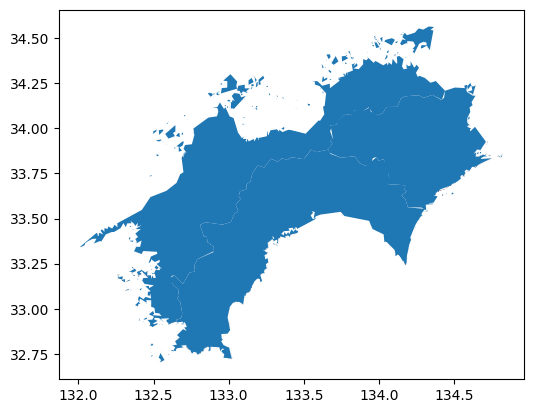

In [13]:
shikoku = ["愛媛県", "香川県", "徳島県", "高知県"]
gdf_japan_processed[gdf_japan_processed["prefecture"].isin(shikoku)].plot()

### 書き出し

In [14]:
gdf_japan_processed.to_file(
    PROCESSED_DATA_DIR / "prefectures.geojson", driver="GeoJSON"
)